In [1]:
#Info about the variables

In [34]:
# Initial imports
import pandas as pd
from pathlib import Path

from sklearn import tree
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf

In [3]:
# Loading data
file_path = Path("Resources/retail_price_cleaned.csv")
df_sales = pd.read_csv(file_path)
df_sales.head()

,product_id,product_category_name,month_year,qty_sold,total_price,freight_price,unit_price,product_rating,no_customers,month,...,comp1_price,comp1_prod_rating,comp1_freight_price,comp2_price,comp2_prod_rating,comp2_freight_price,comp3_price,comp3_prod_rating,comp3_freight_price,lag_price
0,bed1,bed_bath_table,01-05-2017,1,45.95,15.100000,45.95,4.0,57,5,...,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,137.85,12.933333,45.95,4.0,61,6,...,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,275.70,14.840000,45.95,4.0,123,7,...,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,183.80,14.287500,45.95,4.0,90,8,...,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,91.90,15.100000,45.95,4.0,54,9,...,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [4]:
df_sales.nunique()

product_id                52
product_category_name      9
month_year                20
qty_sold                  66
total_price              573
freight_price            653
unit_price               280
product_rating            11
no_customers              94
month                     12
year                       2
seasonality              450
volume                    40
comp1_price               88
comp1_prod_rating          9
comp1_freight_price      179
comp2_price              123
comp2_prod_rating         10
comp2_freight_price      242
comp3_price              105
comp3_prod_rating          9
comp3_freight_price      229
lag_price                307
dtype: int64

## EDA

In [5]:
# Turn dates into datetime for "year","month","month_year"
df_sales['year'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.year 
df_sales['month'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.month
df_sales['month_year'] = pd.to_datetime(df_sales['month_year'], format='%d-%m-%Y').dt.strftime('%Y-%m') #.d

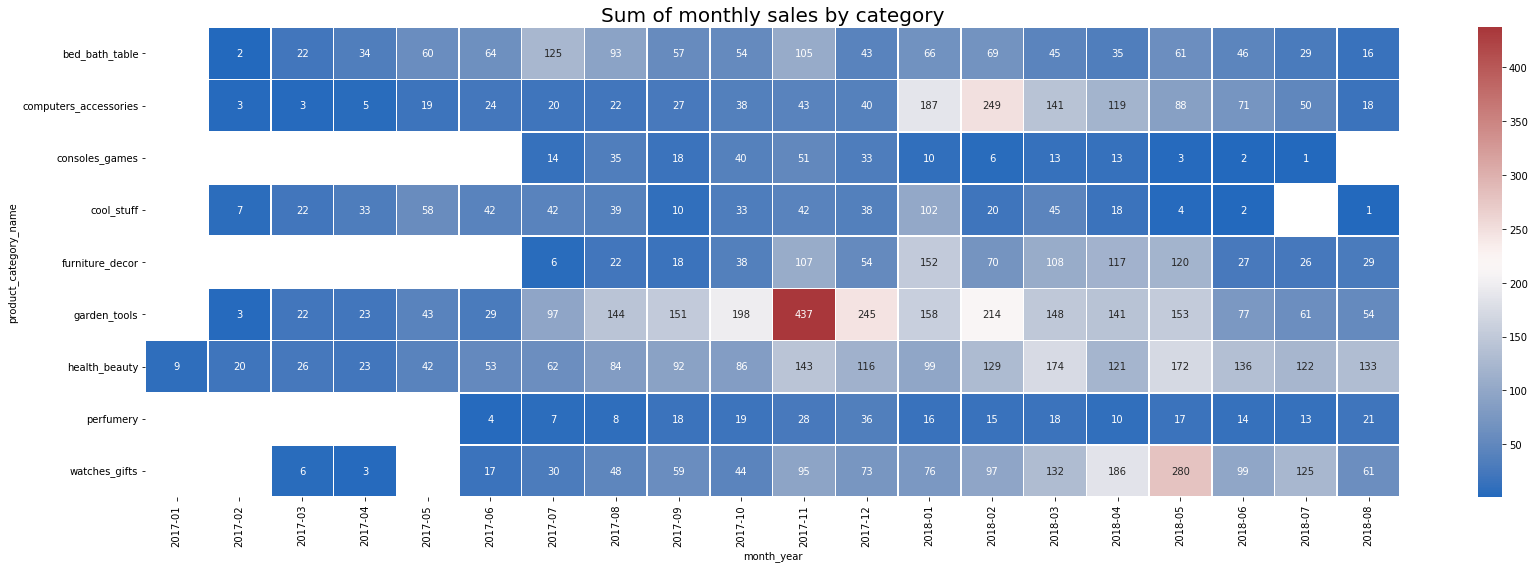

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create pivot table Quantity sold per Date Vs. product_category_name by month
temp = df_sales.pivot_table(
    values='qty_sold',
    index='product_category_name',
    columns='month_year',
    aggfunc='sum',
    ) 
    
# adjust size
fig,ax = plt.subplots(figsize=(24, 8))

# Create heatmap of the above pivot_table.
fig = sns.heatmap(temp, annot=True, fmt='.0f',  linewidths=.5, cmap= 'vlag')

#Set title
ax.set_title('Sum of monthly sales by category', y=-0.5, fontsize=20);

#Rotate x axis
ax.tick_params(axis='x', rotation=90)

#Plot
plt.tight_layout()

In [12]:
df_sales_copy = df_sales.copy()

## Prep

In [13]:
# Drop uneeded columns
df_sales_copy.drop(['product_id','month_year', 'year', 'qty_sold', 'lag_price', 'product_category_name'], axis=1, inplace=True)


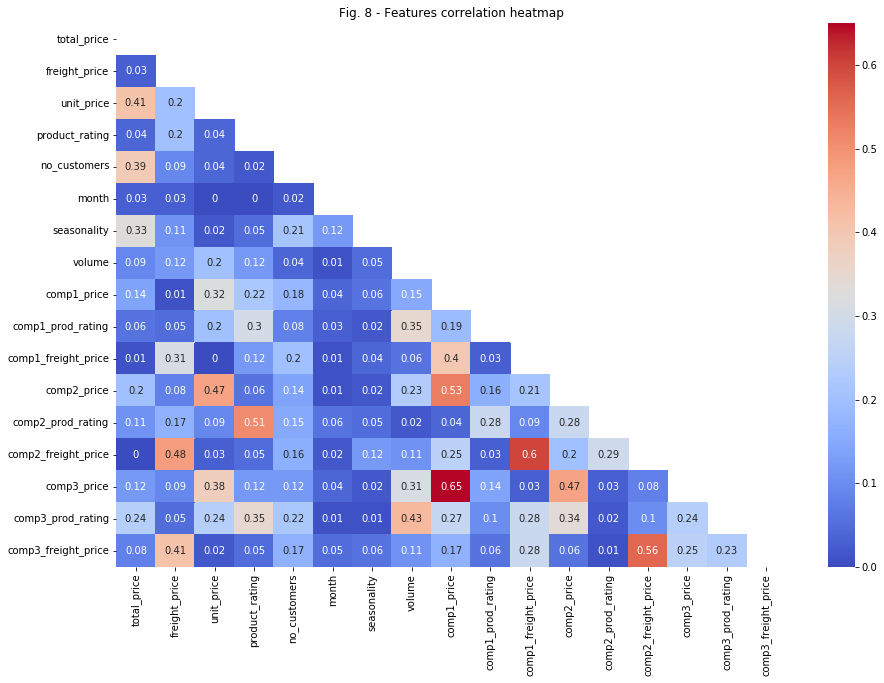

In [14]:
#Correlation heatmap
import numpy as np
fig, ax = plt.subplots(figsize=(15, 10))

matrix = np.triu(df_sales_copy.corr())  
fig = sns.heatmap(round(abs(df_sales_copy.corr()),2), annot=True,  cmap= 'coolwarm', mask=matrix) #, vmin=-1, vmax=1, center= 0, fmt='.02g',
ax.set_title('Fig. 8 - Features correlation heatmap', y=-0.15, fontsize=12);

## ML modeling

In [20]:
# Seperate the features, X,  from the target variable, y
y = df_sales_copy['unit_price']
X = df_sales_copy.drop(columns='unit_price').values

In [21]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [22]:
#Scale

# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [31]:
X_train_scaled

array([[-0.81015466,  4.63949089,  0.06238507, ..., -0.64336634,
         0.46998773,  0.22468061],
       [ 0.4704281 , -0.26426872,  0.06238507, ..., -0.51524212,
         0.46998773, -0.17675852],
       [ 0.32868224, -0.55281129,  0.48980709, ...,  2.04724222,
        -0.80425707, -0.51960666],
       ...,
       [-0.75345631, -0.84384528,  0.91722912, ..., -0.72686062,
         1.31948426, -1.0003509 ],
       [-0.8265408 , -0.23581001,  0.48980709, ..., -1.02133278,
         0.89473599,  0.10221239],
       [-0.06361118, -0.40571468,  0.48980709, ...,  2.17664768,
        -0.80425707,  0.1632439 ]])